<a href="https://colab.research.google.com/github/mpedraza98/MLTSA22_MPedraza/blob/main/HW4/MP_uberprophet_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<span style='color:red'> FBB : this was a well curated homework but you made a mistake in the interpretation of rchi2 throughout which lead you to make incorrect considerations (and kind of blinded you from some obvious results that you could have grasped from the plots). I am sure that if you were working in a group this would have not happened and you would have learned a lot more </span>

This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



In [ ]:
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [ ]:
!pip install fbprophet

In [ ]:
import fbprophet

In [ ]:
from fbprophet import Prophet
from fbprophet import diagnostics

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [ ]:
uberrides = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv', sep =',')
for mon in ['may','jun','jul','aug','sep']:
  mes = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-' + mon + '14.csv'
  temp = pd.read_csv(mes)
  uberrides = pd.concat([uberrides,temp], ignore_index = True)

In [ ]:
uberrides.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [ ]:
uberrides.shape

(4534327, 4)

# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride. 
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group. 

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [ ]:
uberrides.columns

Index(['Date/Time', 'Lat', 'Lon', 'Base'], dtype='object')

In [ ]:
uberrides["time"] = pd.to_datetime(uberrides['Date/Time'])

In [ ]:
uberbyday = uberrides[['Lat']].groupby(uberrides["time"].dt.date).count().reset_index()
uberbyday.rename(columns = {'time':'ds', 'Lat':'y'}, inplace = True)

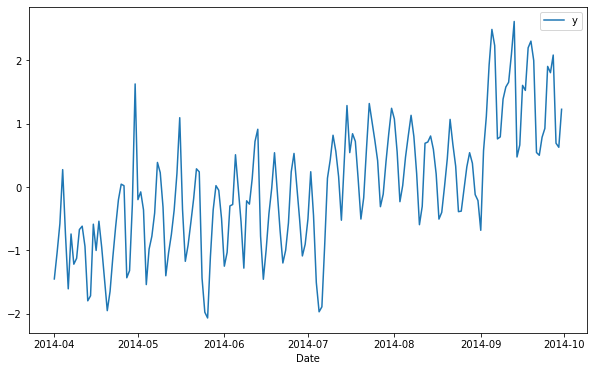

In [ ]:
uberbyday.plot(x="ds", y="y", figsize = (10,6));
pl.xlabel("Date");

**Fig 1.** Standardized time series corresponding to the number of Uber rides in NYC between March and September, 2014.

<span style='color:red'> good but also describe what you see: you can already notice an overall growth trend, a seasonality on short time scales, some points that are higher or lower than expected from the trend and seasonality, and a break in the distribution with a change on 2014-09. These considerations justify the rest of the analysis and the construction of complex models</span>

# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

In [ ]:
stat = uberbyday["y"].mean(), uberbyday["y"].std()
uberbyday["y"] = (uberbyday["y"] - stat[0])/ stat[1]

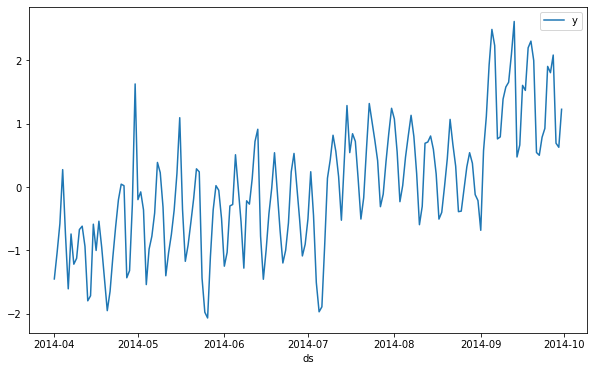

In [ ]:
uberbyday.plot(x="ds", y="y", figsize = (10,6));

**Fig 2** Uber trips by day after standardization. The data now is distributed with zero mean, and unit standard deviation

<span style='color:red'> good. "and _in_ units of standard deviation"</span>

# DATA ANALYSIS fit the uber rides data with the prophet model. 
# MODEL 1: trends and seasonality
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [ ]:
uberbyday.shape

(183, 2)

In [ ]:
simplem = Prophet()
simplem.fit(uberbyday)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
uberbyday.tail()

,ds,y
178,2014-09-26,1.802925
179,2014-09-27,2.081164
180,2014-09-28,0.691101
181,2014-09-29,0.626642
182,2014-09-30,1.225904


In [ ]:
from datetime import datetime  
from datetime import timedelta

In [ ]:
future = []
for i in range(1,31):
  future.append(uberbyday.ds.values[-1] + timedelta(days=i))

In [ ]:
days = pd.DataFrame(np.append(uberbyday.ds.values, future))
days.rename(columns = {0:'ds'}, inplace = True)

In [ ]:
forecast = simplem.predict(days)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
208,2014-10-26,0.683692,0.024777,1.371454
209,2014-10-27,0.962264,0.254872,1.659909
210,2014-10-28,1.539086,0.866844,2.191553
211,2014-10-29,1.896242,1.189859,2.617904
212,2014-10-30,2.214811,1.537664,2.895892


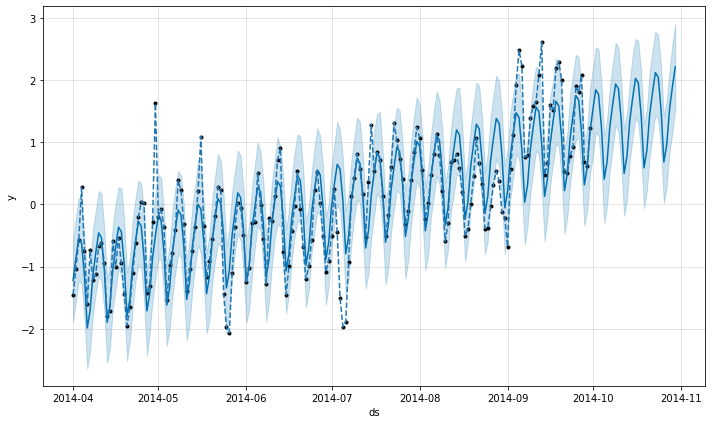

In [ ]:
fig1 = simplem.plot(forecast)
pl.plot(uberbyday.ds, uberbyday.y, '--');

**Fig 3.** The solid line represents the predictions by the Prophet model, with the uncertainty being the shadowed region. while the dashed line is the actual standardized time series plot. 
As can be seen in the plot, the prediction fail to reproduce the behaviour of the data. Although it accounts for the upward trend, it follows a periodic pattern that is not in agreement with the data.

<span style='color:red'> very good!!</span>

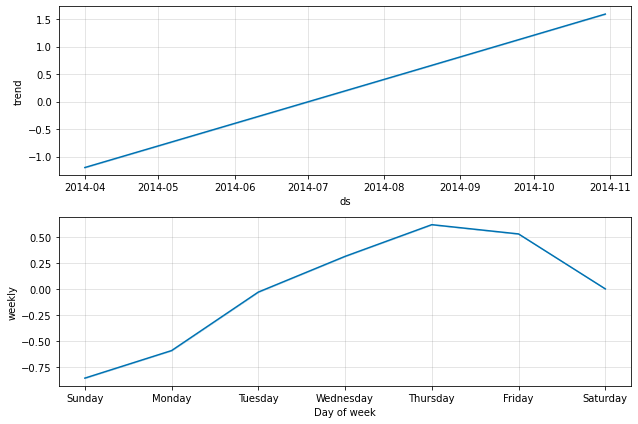

In [ ]:
fig2 = simplem.plot_components(forecast)

**Fig 4.** Components of the seasonality of the model. On the top plot, we see the increasing trend on the number of trips with the month. On the bottom picture is the contribution of each day of the week to the trend. As expected, the days that contribute the second half of the week, close to the weekend.

<span style='color:red'>ver good </span>

# DATA ANALYSIS: model validatoin
 Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [ ]:
def rchi2(y, ytrue):
  # Returns the chi-squared value for the predicted and true values
  # Since we do not consider the uncertainties, we set them equal to one
  return np.sum((ytrue - y)**2)/y.size

In [ ]:
df_cv = diagnostics.cross_validation(simplem, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
rchi2(df_cv.yhat.values, df_cv.y.values)

0.4617232956614481

Crossvalidation is done for 30 days. The chi squared coefficient indicates that the model is not a good representation of the data. It is expected that considering exogenous variables, such as the weather, the model accuracy will improve.

<span style='color:red'>actually the rchi2 says the model is an _unrealistically good_ representation of the data. You _should_ expext rchi2 = 1 _if_ you had properly included your uncertainties. The fact that the models are below 1 mean that they are "too good to be true" because you underestimated the uncertainties. Some times this is used to evaluate our understanding of the uncertainties, and even inflate the uncertainties till the model is ~1. Of course that only work if you _expect_ to have a perfect model </span>

# DATA ACQUISITION 2: dooownload exogenous variable data. 
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [ ]:
#!pip install wwo_hist

In [ ]:
#from wwo_hist import retrieve_hist_data

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/MLTSA22/wwo

/content/gdrive/MyDrive/MLTSA22/wwo


In [ ]:
'''
frequency = 24 #fewquency in hours
start_date = '2014-04-01'
end_date = '2014-09-30'
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)
'''

'\nfrequency = 24 #fewquency in hours\nstart_date = \'2014-04-01\'\nend_date = \'2014-09-30\'\napi_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]\nlocation_list = [\'New+york,ny\']\nhist_weather_data = retrieve_hist_data(api_key,\n                                location_list,\n                                start_date,\n                                end_date,\n                                frequency,\n                                location_label = False,\n                                export_csv = True)\n'

In [ ]:
weather = pd.read_csv("New+york,ny.csv")[['date_time','precipMM','tempC']]
weather.rename(columns = {'date_time':'ds'}, inplace = True)
weather["ds"] = pd.to_datetime(weather["ds"]).dt.date

In [ ]:
weather.tail()

,ds,precipMM,tempC
178,2014-09-26,0.0,27
179,2014-09-27,0.0,30
180,2014-09-28,0.0,26
181,2014-09-29,0.1,25
182,2014-09-30,1.7,21


In [ ]:
uberweather = uberbyday.merge(weather, on = 'ds')    

In [ ]:
#leave
uberweather.head()

,ds,y,precipMM,tempC
0,2014-04-01,-1.449528,0.0,13
1,2014-04-02,-1.034719,0.9,13
2,2014-04-03,-0.577551,0.0,15
3,2014-04-04,0.274309,10.7,7
4,2014-04-05,-0.744721,3.7,10


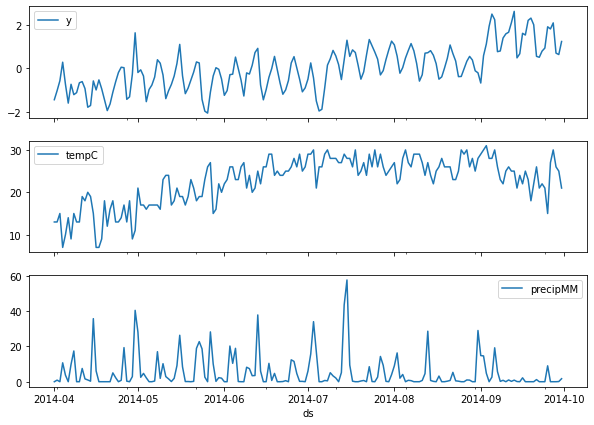

In [ ]:
fig, ax = pl.subplots(3, sharex= True, figsize=(10, 7))
uberweather.plot(x = 'ds', y = "y", ax = ax[0])
uberweather.plot(x = 'ds', y = "tempC", ax = ax[1])
uberweather.plot(x = 'ds', y = "precipMM", ax = ax[2])

**Fig 5** Top plot corresponds to the normalized time series. Middle box displays the temperatures in celcius for NYC. Top plot shows the precipitation. All the data is for the period between March and April 2014.

<span style='color:red'> ok </span>

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [ ]:
regrm = Prophet()

In [ ]:
regrm.add_regressor('precipMM')
regrm.add_regressor('tempC')

In [ ]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 33.0, 'Date')

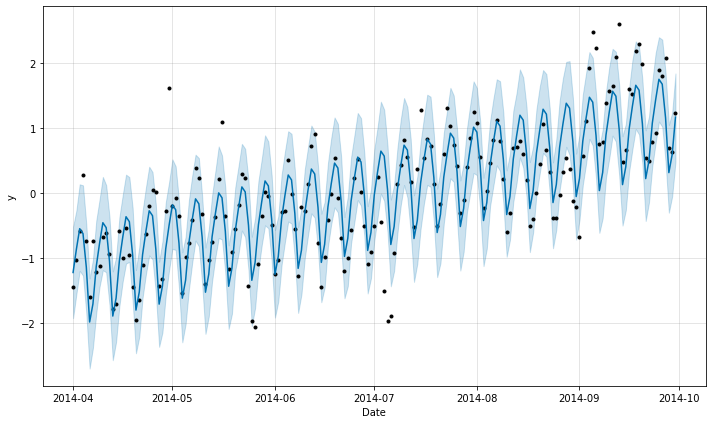

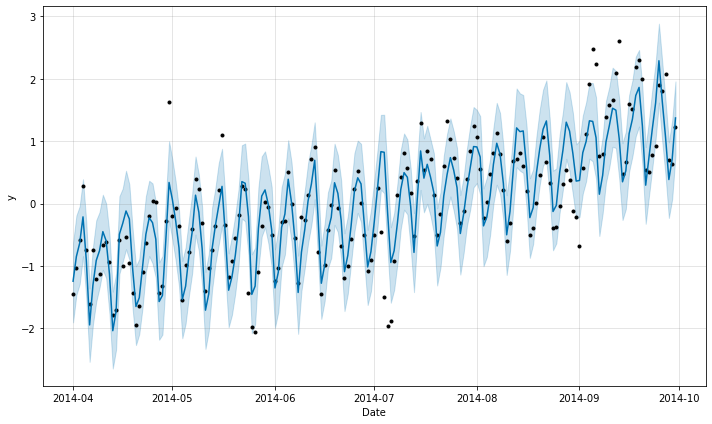

In [ ]:
nowcast = simplem.predict(uberweather)
simplem.plot(nowcast);
pl.xlabel('Date')
nowcast = regrm.predict(uberweather)
regrm.plot(nowcast);
pl.xlabel('Date')

**Fig 6.** Top plot. Original model with data predicted using the dataset that includes the weather information. 
Bottom plot: Model After considering the exogenous variables. We can that compared with the previous model, now there are some variations in the height of the peaks, it might indicate a better fit for the data. However, after looking at the chi squared test, such improvement is marginal. 

<span style='color:red'> good. in fact what I see is that no points are included in the error bars in the bottom plot that were not already included in the top plot, and some are now out (2014-09)</span>

In [ ]:
df_cv = diagnostics.cross_validation(regrm, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
rchi2(df_cv.yhat.values, df_cv.y.values)

0.4767562557266223

# MODEL 3 add holidays
Holiday of course affect traffic and ridership. Prophoet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [ ]:
regholm=Prophet(weekly_seasonality= True)

In [ ]:
regholm.add_country_holidays('US')

In [ ]:
regholm.add_regressor('precipMM')
regholm.add_regressor('tempC')

In [ ]:
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 33.0, 'Date')

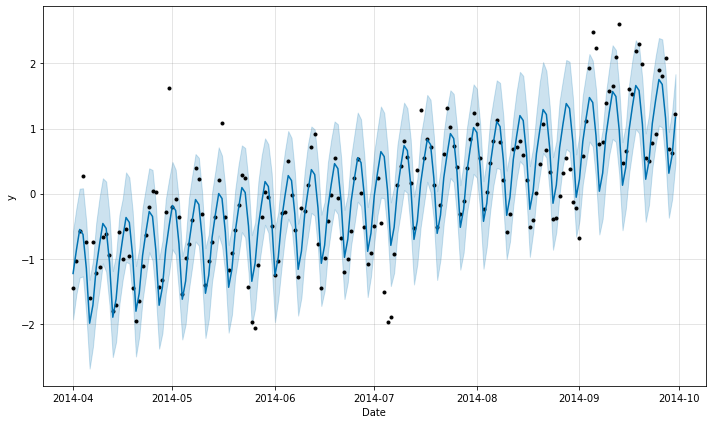

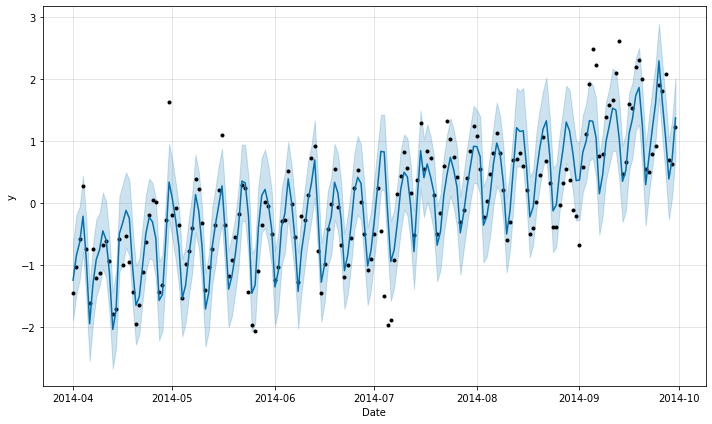

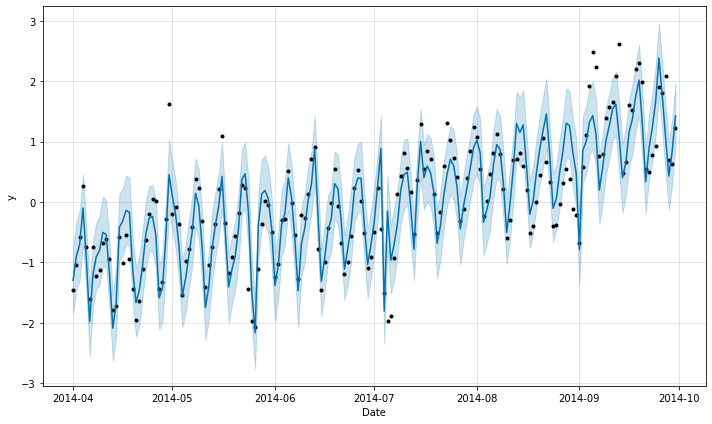

In [ ]:
nowcast = simplem.predict(uberweather)
simplem.plot(nowcast);
pl.xlabel('Date')
nowcast = regrm.predict(uberweather)
regrm.plot(nowcast);
pl.xlabel('Date')
nowcast = regholm.predict(uberweather)
regholm.plot(nowcast);
pl.xlabel('Date')

**Fig 7.** Top plot. Original model fitted with the dataset including the weather information. 
Middle plot: Model After considering the exogenous weather variables.
Bottom Plot: Model including the U.S. holidays. Unexpectedly, when comparing the chi squared results with the two previous attempts, there is a decrease in its value. This might signal that in fact the holidays are not a determinant factor in the number of uber trips in NYC.

<span style='color:red'> you are reading the chi2 wrong. If you had worked with others this would have come up in the discussion! that is why even if you are technically solid and can perform the tasks you would benefot from working with others! - your chi2 going smaller means better fit. After all the chi2 is at its core the difference between data and model prediction - smaller chi2 means smaller difference! in fact now the points around 2014-05, 2014-07 and 2014-098 are within the uncertainty</span>

In [ ]:
df_cv = diagnostics.cross_validation(regholm, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
rchi2(df_cv.yhat.values, df_cv.y.values)

0.40528548217055554

# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

In [ ]:
regmcmc = Prophet(mcmc_samples=5000)

In [ ]:
regmcmc.add_country_holidays('US')

In [ ]:
regmcmc.add_regressor('precipMM')
regmcmc.add_regressor('tempC')

In [ ]:
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 33.0, 'Date')

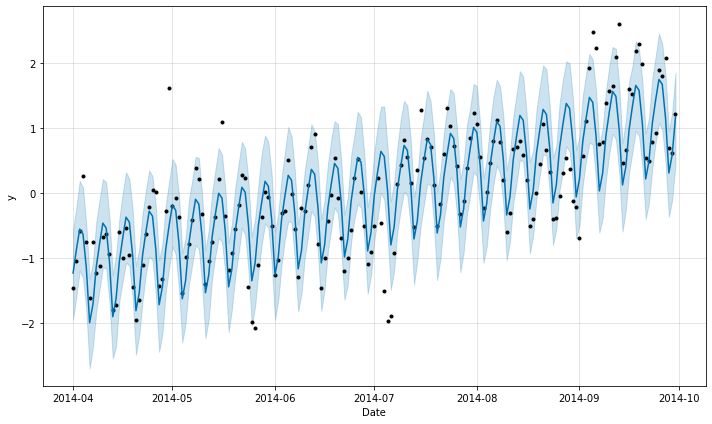

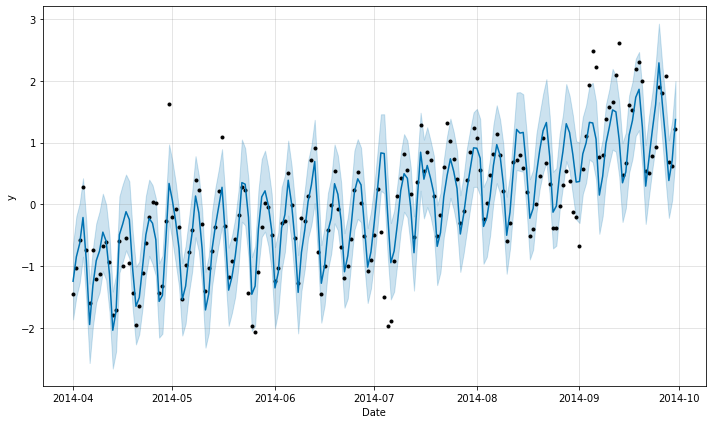

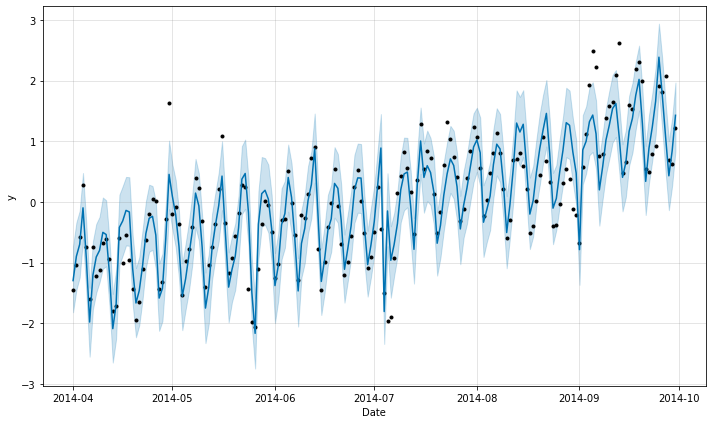

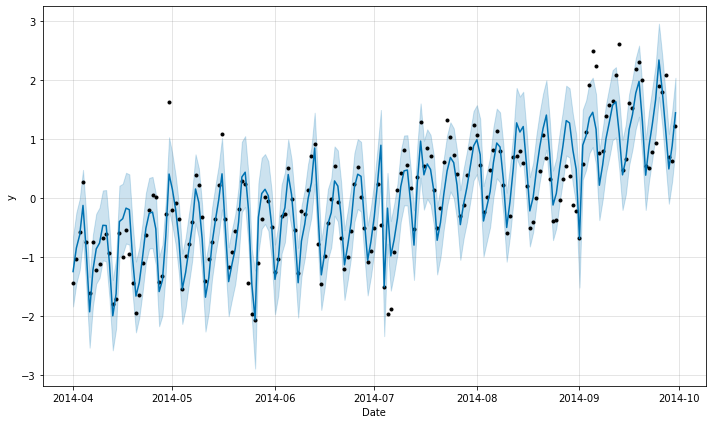

In [ ]:
nowcast = simplem.predict(uberweather)
simplem.plot(nowcast);
pl.xlabel('Date')
nowcast = regrm.predict(uberweather)
regrm.plot(nowcast);
pl.xlabel('Date')
nowcast = regholm.predict(uberweather)
regholm.plot(nowcast);
pl.xlabel('Date')
nowcast = regmcmc.predict(uberweather)
regmcmc.plot(nowcast);
pl.xlabel('Date')

**Fig 8.** The three initial plots are the same as for the previous model. The last one, shows the model after considering a 5000 samples long MCMC. It shows an increase in the goodness of the fit as calculated in the chi squared. However, it is less than the value obtained for the two previous models.

In [ ]:
<span style='color:red'> same issue, but otherwise good</span>

In [ ]:
df_cv = diagnostics.cross_validation(regmcmc, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
rchi2(df_cv.yhat.values, df_cv.y.values)

0.4445343672584267

# Extra Credit
There are two packages with similar functionalities. As extra credit, repeat some of the steps of this analysis with either: Tensorflow timeseries modeling https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html or https://github.com/wwrechard/pydlm